In [1]:
import numpy as np
import pandas as pd
import re
import nltk
nltk.download('wordnet')
nltk.download('stopwords')

from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split
import string
string.punctuation
#importing the Stemming function from nltk library
from nltk.stem.porter import PorterStemmer
#defining the object for stemming
porter_stemmer = PorterStemmer()
from nltk.stem.isri import ISRIStemmer
from textblob import TextBlob

from nltk.stem import WordNetLemmatizer
lemm = WordNetLemmatizer()

!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

# Load The Dataset

In [2]:
import pandas as pd
data = pd.read_csv('/kaggle/input/amazon-books-reviews/Books_rating.csv')

In [3]:
data.head()

,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,1882931173,Its Only Art If Its Well Hung!,NaN,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",7/7,4.0,940636800,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...
1,0826414346,Dr. Seuss: American Icon,NaN,A30TK6U7DNS82R,Kevin Killian,10/10,5.0,1095724800,Really Enjoyed It,I don't care much for Dr. Seuss but after read...
2,0826414346,Dr. Seuss: American Icon,NaN,A3UH4UZ4RSVO82,John Granger,10/11,5.0,1078790400,Essential for every personal and Public Library,"If people become the books they read and if ""t..."
3,0826414346,Dr. Seuss: American Icon,NaN,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",7/7,4.0,1090713600,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D..."
4,0826414346,Dr. Seuss: American Icon,NaN,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",3/3,4.0,1107993600,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...


# Clean Data

In [4]:
data = data.drop(['Id' , 'Title' , 'Price','User_id','profileName','review/helpfulness','review/time','review/summary'], axis=1)
print(data.head())

   review/score                                        review/text
0           4.0  This is only for Julie Strain fans. It's a col...
1           5.0  I don't care much for Dr. Seuss but after read...
2           5.0  If people become the books they read and if "t...
3           4.0  Theodore Seuss Geisel (1904-1991), aka &quot;D...
4           4.0  Philip Nel - Dr. Seuss: American IconThis is b...


In [5]:
data = data.rename(columns={"review/text":"review" , "review/score":"label"})

In [6]:
data["label"].value_counts()

5.0    1807343
4.0     585616
3.0     254295
1.0     201688
2.0     151058
Name: label, dtype: int64

In [7]:
def mark_sentiment(rating):
    if(rating > 3.0):
        return 2
    elif (rating == 3.0):
        return 1
    else:
        return 0
data["label"] = data['label'].apply(lambda x:mark_sentiment(x))
data["label"].value_counts()

2    2392959
0     352746
1     254295
Name: label, dtype: int64

In [8]:
data.drop_duplicates(inplace=True)
data = data.dropna(axis=0)
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2062913 entries, 0 to 2999999
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   label   int64 
 1   review  object
dtypes: int64(1), object(1)
memory usage: 47.2+ MB
None


In [9]:
data["label"].value_counts()

2    1630523
0     255457
1     176933
Name: label, dtype: int64

In [10]:
print(data.shape)

(2062913, 2)


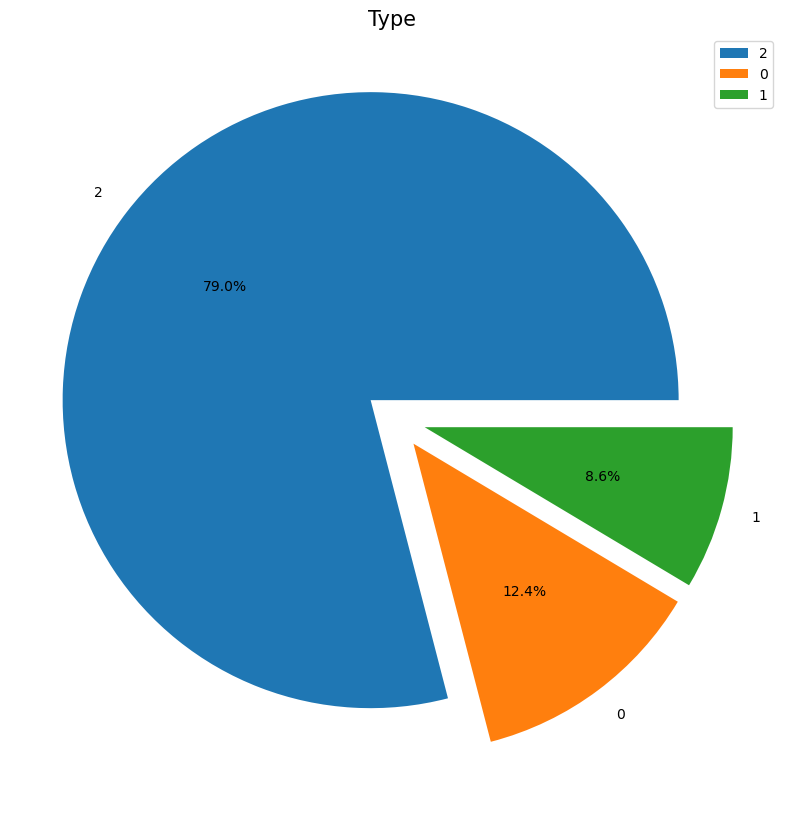

In [11]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 10)
labels=[2,0,1]
plt.pie(data['label'].value_counts(),explode =(0.1,0.1,0.1), labels=labels,autopct='%1.1f%%')
plt.title('Type ', fontsize = 15)
plt.axis('off')
plt.legend()
plt.show()

# Balance Data

In [12]:
class_0 = data[data["label"] == 0]
class_0  = class_0.iloc[:50000]
class_1 = data[data["label"] == 1]
class_1  = class_1.iloc[:40000]
class_2 = data[data["label"] == 2]
class_2  = class_2.iloc[:60000]
data = pd.concat([class_2 , class_0 , class_1])

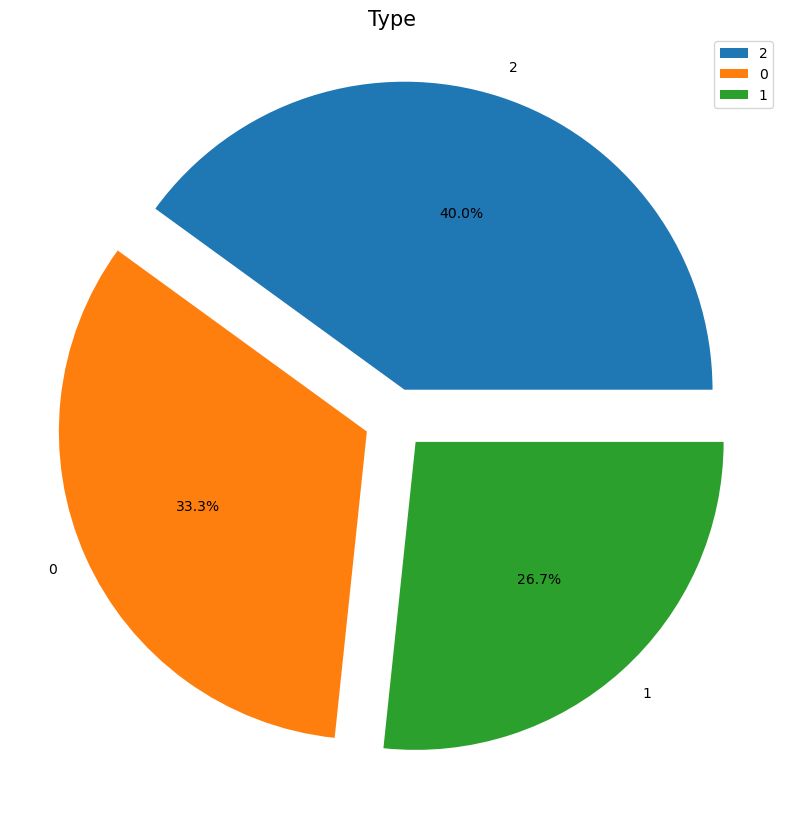

In [13]:
plt.rcParams['figure.figsize'] = (10, 10)
labels=[2,0,1]
plt.pie(data['label'].value_counts(),explode =(0.1,0.1,0.1), labels=labels,autopct='%1.1f%%')
plt.title('Type ', fontsize = 15)
plt.axis('off')
plt.legend()
plt.show()

In [14]:
data = data.sample(frac = 1.0 ,random_state = 23 )

In [15]:
import numpy as np
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda
Tesla T4
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [16]:
import torch
import os

if 'TPU_NAME' in os.environ:
    device = torch.device('tpu')
    print(f'Using TPU: {os.environ["TPU_NAME"]}')
else:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('No TPU detected, using GPU/CPU')

No TPU detected, using GPU/CPU


# Preprocessing

In [19]:
from nltk.corpus import stopwords
def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    
    # Remove punctuation and special characters
    text = re.sub(r'[^\w\s]', '', text)
    
    # Lowercase the text
    text = text.lower()
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [word for word in words if word not in stop_words]
    text = ' '.join(words)
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words]
    text = ' '.join(words)
    
    return text

In [20]:
data['review'] = data['review'].apply(lambda x:clean_text(x))

## Split the dataset into training and testing sets

In [21]:
X_train, X_test, y_train, y_test = train_test_split(data['review'], data['label'], test_size=0.2, random_state=42)

# Tokenize the text data

In [22]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

## Pad the sequences to the same length


In [23]:
max_length = 100
X_train = pad_sequences(X_train, maxlen=max_length)
X_test = pad_sequences(X_test, maxlen=max_length)

## Load the GloVe word embeddings

In [24]:
embedding_dict = {}
with open('/kaggle/input/glove6b100dtxt/glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coeffs = np.asarray(values[1:], dtype='float32')
        embedding_dict[word] = coeffs

# Create the embedding matrix
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
    embedding_vector = embedding_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Create LSTM Model

## Define the LSTM model

In [25]:
model = Sequential()
model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_length, trainable=True))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))

## Compile the model


In [26]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Convert the labels to one-hot encoding

In [27]:
y_train = pd.get_dummies(y_train).values
y_test = pd.get_dummies(y_test).values

## Train the model

In [28]:
from keras.callbacks import EarlyStopping
history = model.fit(X_train, y_train, epochs=10, batch_size=1024 , validation_split=0.1,
                   verbose=1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/10
106/106 [==============================] - 81s 705ms/step - loss: 0.9010 - accuracy: 0.5744 - val_loss: 0.7735 - val_accuracy: 0.6517
Epoch 2/10
106/106 [==============================] - 68s 639ms/step - loss: 0.7403 - accuracy: 0.6703 - val_loss: 0.7148 - val_accuracy: 0.6847
Epoch 3/10
106/106 [==============================] - 64s 599ms/step - loss: 0.6797 - accuracy: 0.7030 - val_loss: 0.6889 - val_accuracy: 0.7017
Epoch 4/10
106/106 [==============================] - 61s 570ms/step - loss: 0.6439 - accuracy: 0.7190 - val_loss: 0.6701 - val_accuracy: 0.7106
Epoch 5/10
106/106 [==============================] - 61s 577ms/step - loss: 0.6194 - accuracy: 0.7328 - val_loss: 0.6704 - val_accuracy: 0.7124
Epoch 6/10
106/106 [==============================] - 57s 533ms/step - loss: 0.6011 - accuracy: 0.7409 - val_loss: 0.6604 - val_accuracy: 0.7166
Epoch 7/10
106/106 [==============================] - 56s 526ms/step - loss: 0.5821 - accuracy: 0.7520 - val_loss: 0.6671 - val_ac

## Evaluate the model on the test set

In [29]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
yy_test = np.argmax(y_test, axis=1)
print(classification_report(yy_test, y_pred))

loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Test Accuracy: {:.4f}".format(accuracy))

938/938 [==============================] - 32s 34ms/step
              precision    recall  f1-score   support

           0       0.76      0.69      0.72     10109
           1       0.56      0.60      0.58      7991
           2       0.80      0.83      0.81     11900

    accuracy                           0.72     30000
   macro avg       0.71      0.70      0.70     30000
weighted avg       0.72      0.72      0.72     30000

Test Accuracy: 0.7192


## Predict the sentiment of a new tweet

In [30]:
def predict_sentiment(tweet):
    tweet = re.sub(r'[^\w\s]', '', tweet.lower())
    tweet_sequence = tokenizer.texts_to_sequences([tweet])
    tweet_padded = pad_sequences(tweet_sequence, maxlen=max_length)
    sentiment = model.predict(tweet_padded)[0]
    if np.argmax(sentiment) == 0:
        return "negative"
    elif np.argmax(sentiment) == 1:
        return "neutral"
    else:
        return "positive"


In [31]:
# Example usage
new_tweet = input("Enter a new tweet: ")
predicted_sentiment = predict_sentiment(new_tweet)
print("Predicted sentiment:", predicted_sentiment)

Enter a new tweet:  good place


1/1 [==============================] - 0s 51ms/step
Predicted sentiment: positive


# Plot LSTM Model

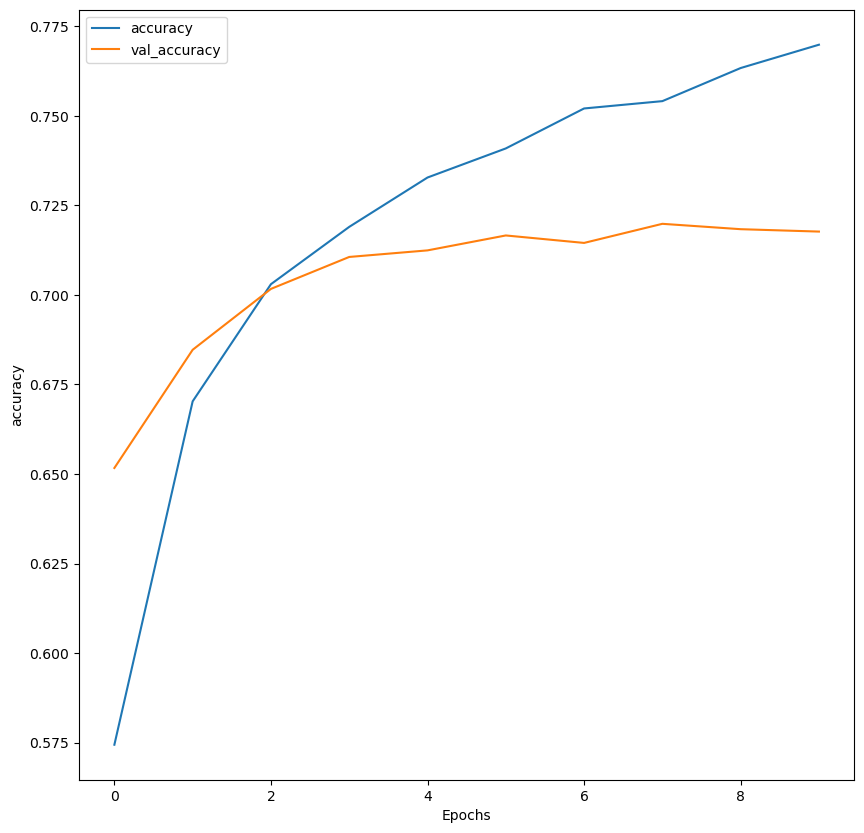

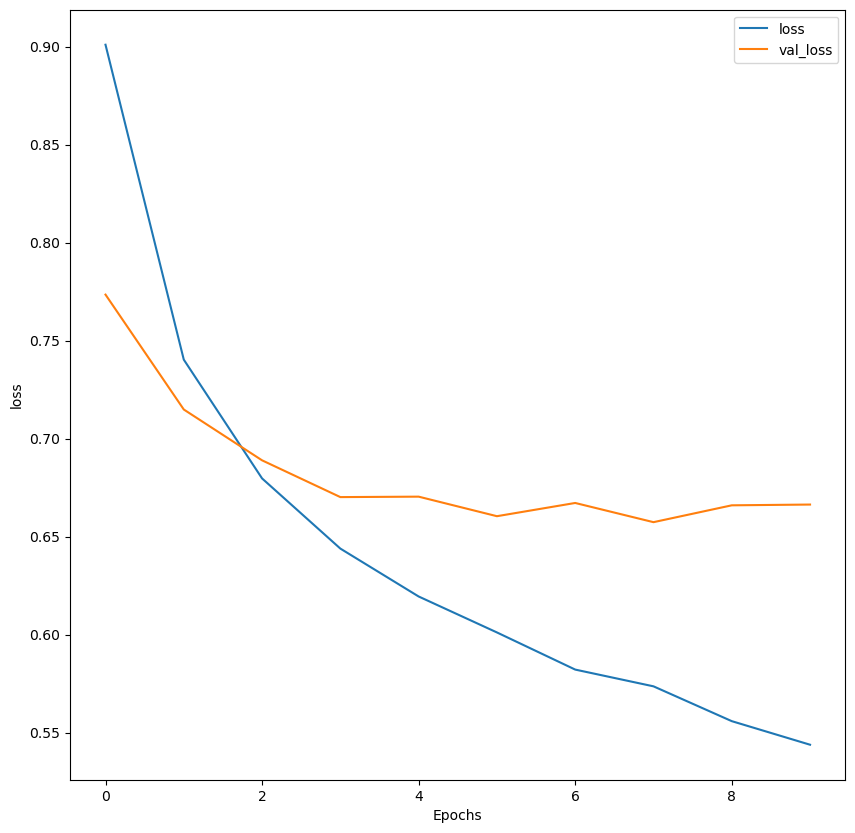

In [32]:
import matplotlib.pyplot as plt
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## Confusion Matrix for LSTM Model

In [33]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

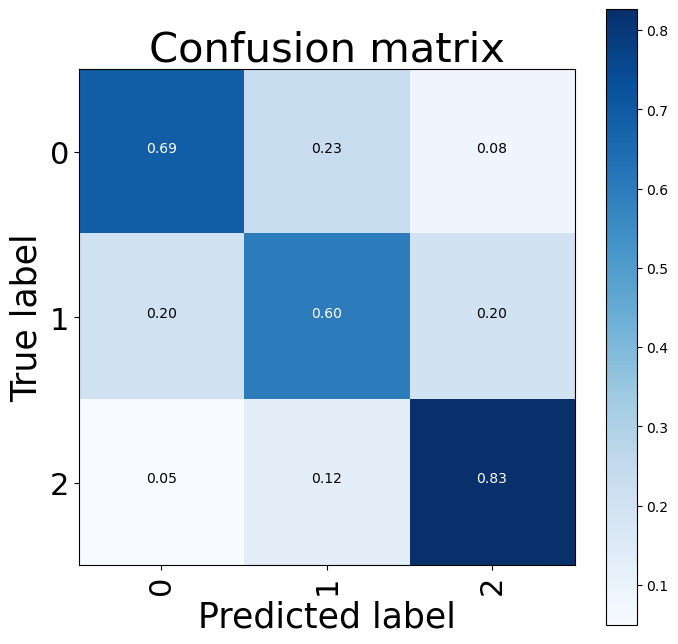

In [34]:
import itertools
cnf_matrix = confusion_matrix(yy_test, y_pred)
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes={0,1,2}, title="Confusion matrix")
plt.show()